In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
from ast import literal_eval
from nltk.stem.snowball import SnowballStemmer
import numpy as np
import warnings
import pickle
warnings.filterwarnings('ignore')
from keras.layers import Input, Embedding, Flatten, Dot, Dense , Concatenate , StringLookup, BatchNormalization,Dropout
from keras.models import Model , load_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
tf.random.set_seed(42)
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.metrics import r2_score
from surprise import Reader, Dataset, SVD , dump
from surprise.model_selection import cross_validate
from sklearn.metrics import confusion_matrix , classification_report
from sklearn import preprocessing
from collections import defaultdict
from surprise.model_selection import KFold
from sklearn.metrics import RocCurveDisplay
import os
import random
random.seed(42)
np.random.seed(42)
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import os # accessing directory structure
import keras
from keras import Model
from tensorflow.keras.applications import ResNet50
from keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
import cv2
import urllib.request
from tensorflow.keras.utils import img_to_array
import requests
import PIL.Image as Image
import io
from tensorflow.keras.utils import warmstart_embedding_matrix
from keras.layers import Input, Embedding, Flatten, Dot, Dense , Concatenate , StringLookup, BatchNormalization,Dropout 
from keras.models import Model , load_model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras

from recbole.model.sequential_recommender import BERT4Rec 
import pandas as pd
from recbole.evaluator.metrics import RMSE , MAE , Hit , NDCG , Recall , MRR
import logging
from logging import getLogger
from recbole.config import Config
from recbole.data import create_dataset , data_preparation
from recbole.trainer import Trainer
from recbole.utils import init_seed, init_logger
import numpy as np
import torch
from collections import defaultdict
from recbole.evaluator.metrics import Hit , NDCG , Recall
from recbole.quick_start import run_recbole , load_data_and_model
import torch
from recbole.data.interaction import Interaction
import csv
import datetime
tf.random.set_seed(42)

In [2]:
dataPath = 'C:\\Users\\Sigma\\ecommerce\\allData.csv'
ratingPath = 'C:\\Users\\Sigma\\ecommerce\\both3.csv'
df2= pd.read_csv(dataPath)
df3= pd.read_csv(ratingPath)

In [3]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['category'])

stemmer = SnowballStemmer('english') # playing--->play
analyzer = TfidfVectorizer().build_analyzer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))
tfidf = TfidfVectorizer( analyzer = stemmed_words ,
                         ngram_range=(1,1),
                         min_df=3/31858, # if the word is repeated less than three times then I dont care about it
                         max_df=0.5, # if the word is repeated more than 50% then I don't care about it
                         stop_words='english')
tfidf_matrix = tfidf.fit_transform(  df2['feature']  )

img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model_img = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])



In [4]:
with open(r'C:\Users\Sigma\ecommerce\images_emb.pkl','rb') as f:
                df_embs = pickle.load(f)

In [5]:
ggg = df3.sort_values(by=['timestamp'])
ggg = ggg.rename(columns={'userID': 'user_id:token', 'itemID': 'item_id:token', 'rating': 'rating:token' ,'timestamp': 'timestamp:float'})
ggg.to_csv(r'C:\Users\Sigma\ecommerce\old&new_condition.inter', index=False, sep='\t')

In [6]:
# this cell is made to empty the new_all
empty = pd.read_csv(r"C:\Users\Sigma\ecommerce\new_all.csv")
empty = empty[0:0]
empty.to_csv(r'C:\Users\Sigma\ecommerce\new_all.csv', index=False)


In [7]:
def img_show_asin(asin , x=0):
    if x == 1:
        img = cv2.imread('C:\\Users\\Sigma\\ecommerce\\images' + "\\" + asin + '.jpg')
    else:
        response = requests.get(literal_eval(df2[df2['asin'] == asin]['imageURLHighRes'].values[0])[0])
        img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.title(label= '{}  '.format(round(df2[df2['asin'] == asin]['vote_average'].values[0],2)) ,
          loc="right",
          color='red' , fontsize=18)
    plt.axis('off')
    plt.show()
    

In [8]:
def get_recommendations(asin, cosine_sim , indices , numItems):
    

    
    # Get the index of the movie that matches the asin number
    idx = indices[asin]

    # Get the similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx])) # list of tuples [(0,1) , (1,0.5)]

    # Sort the products based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar products
    sim_scores = sim_scores[1:numItems+1]  # don't take 0 as we don't take the score with the same product

    # Get the movie indices
    product_indices = [i[0] for i in sim_scores]
    arr =  np.array(df2['asin'].iloc[product_indices])
    
    return (arr)


    


In [9]:
def get_embedding1(model, asin):
    # Reshape 
    img = cv2.imread('C:\\Users\\Sigma\\ecommerce\\images' + "\\" + asin + '.jpg')
        
    if img.shape[2] == 1:
        img = cv2.merge((img,img,img))   
    
    
    #img = tf.keras.utils.load_img(img, target_size=(img_width, img_height))
    
    width = 224
    height = 224
    
    dsize = (width, height)
    output = cv2.resize(img, dsize)
    
    # img to Array
    x   = img_to_array(output)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x , verbose = 1).reshape(-1)

In [10]:
def collaborative_recommendation(userId , top_n, ratings):
    
    a = ratings[ratings['userID'] == userId]
    
    asinArr = []
    for asin in top_n[userId]:
        a = a[a['itemID'] == asin]
        if (a.empty):
            asinArr.append(asin[0])
    return asinArr
        
#         img_show_asin(asin[0])

In [11]:
def transformer (asin, cosine_sim , numItems) :

    
    
    # Get the index of the movie that matches the asin number
    #idx = indices[asin]

    # Get the similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[0]))

    # Sort the products based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar products
    sim_scores = sim_scores[0:numItems] 

    # Get the movie indices
    product_indices = [i[0] for i in sim_scores]
    
    #img_show_indices( product_indices)
                
    # Return the top 10 most similar movies
    arr =  np.array(df2['asin'].iloc[product_indices])

    
    return (arr)

In [12]:
def get_top_n(predictions, n):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [13]:
# return the products that has not been rated yet
def build_anti_testset(self, userId, fill=None ):
        """Return a list of ratings that can be used as a testset in the
        :meth:`test() <surprise.prediction_algorithms.algo_base.AlgoBase.test>`
        method.

        The ratings are all the ratings that are **not** in the trainset, i.e.
        all the ratings :math:`r_{ui}` where the user :math:`u` is known, the
        item :math:`i` is known, but the rating :math:`r_{ui}`  is not in the
        trainset. As :math:`r_{ui}` is unknown, it is either replaced by the
        :code:`fill` value or assumed to be equal to the mean of all ratings
        :meth:`global_mean <surprise.Trainset.global_mean>`.

        Args:
            fill(float): The value to fill unknown ratings. If :code:`None` the
                global mean of all ratings :meth:`global_mean
                <surprise.Trainset.global_mean>` will be used.

        Returns:
            A list of tuples ``(uid, iid, fill)`` where ids are raw ids.
        """
        fill = self.global_mean if fill is None else float(fill)

        anti_testset = []
        user_items = {j for (j, _) in self.ur[userId]}
        anti_testset += [
                (self.to_raw_uid(self.to_inner_uid(userId)), self.to_raw_iid(i), fill)
                for i in self.all_items()
                if i not in user_items
            ]
        return anti_testset


In [14]:


def weighted_rating(x, m, C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [15]:
def topRecom(numPerCategory = 5 ) :
    
    current_db= pd.read_csv(r"C:\Users\Sigma\ecommerce\current_database.csv")
        
    C= current_db['vote_average'].mean()
    m= current_db['vote_count'].quantile(0.9)
    current_db22 = current_db.copy().loc[current_db['vote_count'] >= m]
    
    dataFrameClothing = current_db22[current_db22['category'].str[2:10] == 'Clothing']
    dataFrameHome = current_db22[current_db22['category'].str[2:10] == 'Home & K']
    
    dataFrameClothing['score'] = dataFrameClothing.apply(weighted_rating , args=(m,C), axis=1)
    dataFrameHome['score'] = dataFrameHome.apply(weighted_rating ,args=(m,C) , axis=1)
   
    
    dataFrameClothing = dataFrameClothing.sort_values('score', ascending=False)
    dataFrameHome = dataFrameHome.sort_values('score', ascending=False)
    
    
    arr1 = np.array(dataFrameClothing['asin'][0:round(numPerCategory/2)])
    arr2 = np.array(dataFrameHome['asin'][0:round(numPerCategory/2)])
    
    
    coldstart = np.concatenate((arr1 , arr2 ))

    return coldstart
    

In [18]:
topRecom(5)

array(['B005GYGF5Y', 'B000IF2MKS', 'B006JCWGIC', 'B01CH7TL30'],
      dtype=object)

In [16]:
def contentBased(asin , numItems = 5 ):
    
    if asin in np.array(df2['asin']):
        if os.path.exists(r'C:\Users\Sigma\ecommerce\cosine_sim1.pkl'):
            with open(r'C:\Users\Sigma\ecommerce\cosine_sim1.pkl','rb') as f:
                cosine_sim1 = pickle.load(f)

        else:

            cosine_sim1 = cosine_similarity(tfidf_matrix, tfidf_matrix)
            with open(r'C:\Users\Sigma\ecommerce\cosine_sim1.pkl','wb') as f:
                pickle.dump(cosine_sim1, f)

        

        
        
        if os.path.exists(r'C:\Users\Sigma\ecommerce\cosine_sim4.pkl'):
            with open(r'C:\Users\Sigma\ecommerce\cosine_sim4.pkl','rb') as f:
                cosine_sim4 = pickle.load(f)
        else:
            #count = CountVectorizer(stop_words='english')
            #count_matrix = count.fit_transform(df2['category'])
            cosine_sim4 = cosine_similarity(count_matrix,count_matrix)
            with open(r'C:\Users\Sigma\ecommerce\cosine_sim4.pkl','wb') as f:
                pickle.dump(cosine_sim4, f)

 
    else:
        df_new= pd.read_csv(r"C:\Users\Sigma\ecommerce\current_database.csv")
        x = tfidf.transform(  df_new[df_new['asin']== asin]['feature'] ) #df2[df2['asin']== asin]['description'] + " " +
        cosine_sim_new1 = cosine_similarity(x, tfidf_matrix)
        x = count.transform(  df_new[df_new['asin']== asin]['category'] ) #df2[df2['asin']== asin]['brand'] + " " +
        cosine_sim_new4 = cosine_similarity(x, count_matrix)

    if asin in np.array(df2['asin']):
        indices = pd.Series(df2.index, index=df2['asin']) # this must be the old data
        featureArr = get_recommendations(asin , cosine_sim1  ,indices , round(numItems/2))
        categoryArr = get_recommendations(asin , cosine_sim4  ,indices , round(numItems/2))
    else:
        featureArr = transformer (asin, cosine_sim_new1 , round(numItems/2))
        categoryArr = transformer (asin, cosine_sim_new4 , round(numItems/2))
        
        
    Total = np.concatenate(  ( categoryArr ,  featureArr) , axis = None ) 
    Total = np.unique(Total)

    return (Total)

In [17]:
def imgRecomm(asin , numItems = 5  ):
    if asin in np.array(df2['asin']):

        if (os.path.exists(r'C:\Users\Sigma\ecommerce\cosine_sim3.pkl')) :
            with open(r'C:\Users\Sigma\ecommerce\cosine_sim3.pkl','rb') as f:
                cosine_sim3 = pickle.load(f)
        else:

            cosine_sim3 = cosine_similarity(df_embs,df_embs)
            with open(r'C:\Users\Sigma\ecommerce\cosine_sim3.pkl','wb') as f:
                pickle.dump(cosine_sim3, f)
    
    else:
        df_new= pd.read_csv(r"C:\Users\Sigma\ecommerce\current_database.csv")
        x = get_embedding1(model_img, asin).reshape(1,-1)
        cosine_sim_new3 = cosine_similarity(x, df_embs)
            
    
    
    if asin in np.array(df2['asin']):
        indices3 = pd.Series(df2.index, index=df2['asin'])
        imgarr = get_recommendations( asin, cosine_sim3 , indices3 , numItems )
    else:
        imgarr = transformer (asin, cosine_sim_new3 , numItems)

        
    
    return (imgarr)

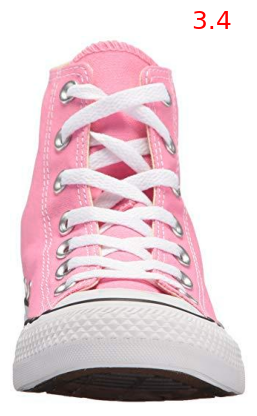

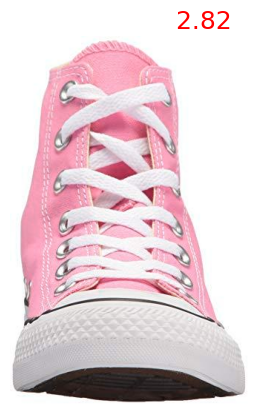

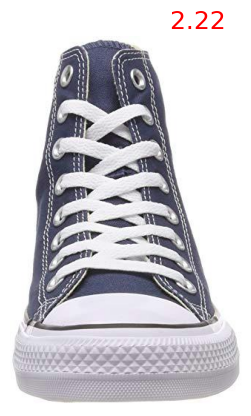

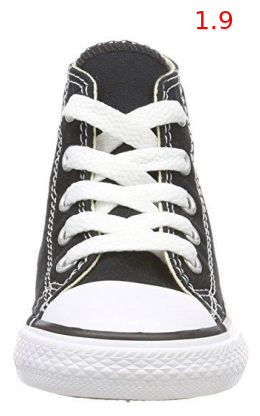

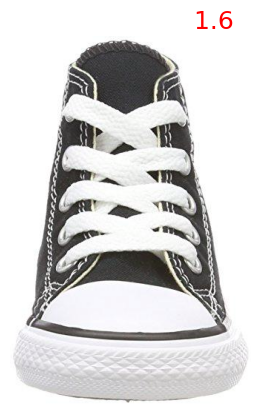

In [24]:
arr = imgRecomm('B0000A6XS9' , 5)
for asin in arr:
    img_show_asin(asin , 1)

In [18]:
def collabrative (user , numItems = 5   ):
    from surprise.model_selection import train_test_split
    ratings = pd.read_csv(r"C:\Users\Sigma\ecommerce\current_rating.csv")
    ratings = pd.read_csv(ratingPath)
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(ratings[['userID', 'itemID', 'rating']], reader)
    real_trainset = data.build_full_trainset()
    if os.path.exists(r'C:\Users\Sigma\ecommerce\dump_file'):
        file_name = os.path.expanduser(r"C:\Users\Sigma\ecommerce\dump_file")
        _,svd = dump.load(file_name)
       
    else:
    
        
        svd = SVD(n_factors= 30 , n_epochs= 20 , lr_all = 0.005 , reg_all = 0.02 , random_state=42  )
        svd.fit(real_trainset)


    
   

    real_testset = build_anti_testset(real_trainset   , user )
    predictions = svd.test(real_testset)
    top_n = get_top_n(predictions, n=numItems)
    
    
    return (collaborative_recommendation(user , top_n , ratings))

In [122]:
def embedding(userId , numItems = 5 ):
    from sklearn.model_selection import train_test_split
    
    ratings_dataset = pd.read_csv(ratingPath)
    if os.path.exists(r'C:\Users\Sigma\ecommerce\embedding_model.h5'):
        model2 = load_model(r'C:\Users\Sigma\ecommerce\embedding_model.h5')
        import gc
        for obj in gc.get_objects():   # Browse through ALL objects
            if isinstance(obj, h5py.File):   # Just HDF5 files
                try:
                    obj.close()
                except:
                    pass # Was already closed
        
    else:
        

        n_users = len(ratings_dataset['userID'].unique())
        n_items = len(ratings_dataset['itemID'].unique()) 
        
        userId_lookup = StringLookup(vocabulary = ratings_dataset['userID'].unique(), mask_token = None )
        asin_lookup = StringLookup(vocabulary = ratings_dataset['itemID'].unique(), mask_token = None )


        item_input = Input(shape=[1],name='item-input'  , dtype= object)
        user_input = Input(shape=[1], name='user-input' , dtype= object)

        # MLP Embeddings
        item_input1 = asin_lookup(item_input)
        user_input1 = userId_lookup(user_input)

        item_embedding_mlp = Embedding(n_items + 1, 16, name='item-embedding-mlp'  )(item_input1)
        item_vec_mlp = Flatten(name='flatten-item-mlp')(item_embedding_mlp)

        user_embedding_mlp = Embedding(n_users + 1, 16, name='user-embedding-mlp' )(user_input1)
        user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

        # MF Embeddings
        item_embedding_mf = Embedding(n_items + 1, 16, name='item-embedding-mf' , embeddings_regularizer='L2' )(item_input1)
        item_vec_mf = Flatten(name='flatten-item-mf')(item_embedding_mf)

        user_embedding_mf = Embedding(n_users + 1, 16, name='user-embedding-mf' , embeddings_regularizer='L2' )(user_input1)
        user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

        # MLP layers

        concat = Concatenate()([item_vec_mlp, user_vec_mlp])
        concat_dropout = Dropout(0.5)(concat)

        fc_1 = Dense(128, name='fc-1', activation='relu')(concat_dropout)
        fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
        fc_1_dropout = Dropout(0.5)(fc_1_bn)

        fc_2 = Dense(64, name='fc-2', activation='relu')(fc_1_dropout)
        fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
        fc_2_dropout = Dropout(0.5)(fc_2_bn)





        # Prediction from both layers
        pred_mlp = Dense(16, name='pred-mlp', activation='relu' )(fc_2_dropout)



        pred_mf = Dot(name="Dot-Product", axes=1)([item_vec_mf, user_vec_mf])
        combine_mlp_mf = Concatenate()([pred_mf, pred_mlp])

        # Final prediction
        result = Dense(1, name='result', activation='relu' )(combine_mlp_mf)

        model2 = Model([user_input, item_input], result)
        model2.compile(optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.001), loss= tf.keras.losses.mean_absolute_error  , metrics= tf.keras.metrics.RootMeanSquaredError(
            name="root_mean_squared_error", dtype=None))
        
        history = model2.fit([ratings_dataset.userID, ratings_dataset.itemID], ratings_dataset['rating'] , batch_size=64  , epochs=2,  verbose=1 )
        model2.save(r'C:\Users\Sigma\ecommerce\embedding_model.h5')
        
    ratings_dataset2 = pd.read_csv(r"C:\Users\Sigma\ecommerce\current_rating.csv")
    item_data = np.array(list(set(ratings_dataset2.itemID)))
    user = np.array([userId for i in range(len(item_data))])
    predictions = model2.predict([user, item_data])

    predictions = np.array([a[0] for a in predictions])

    recommended_indices = (-predictions).argsort()
    item_data[recommended_indices]
    #     img_show_indices(recommended_indices[0:10])
    a = ratings_dataset2[ratings_dataset2['userID'] == userId]['itemID']
    arr =  np.array(df2[df2['asin'].isin(item_data[recommended_indices]) & df2['asin'].isin(a)==0]['asin'])
    arr= arr[0:numItems]
    return arr     

In [5]:
model2 = load_model(r'C:\Users\Sigma\ecommerce\embedding_model.h5')
print(model2)

OSError: Unable to open file (file signature not found)

In [124]:
def warmStartEmbedding(): # it's working whenever a change occurs in the database
    ratings_dataset = pd.read_csv(ratingPath)
    model2 = load_model(r'C:\Users\Sigma\ecommerce\embedding_model.h5')
    model2.summary()
#     with open(r'C:\Users\Abdo\Desktop\last year\project\datasets\last datataset isa\embedding_model.pkl','rb') as f:
#                 model2 = pickle.load(f)
    base_vocabulary_user = ratings_dataset['userID'].unique()
    base_vocabulary_item = ratings_dataset['itemID'].unique()
    # old_text_vectorization_layer.get_vocabulary()
    new = pd.read_csv(r'C:\Users\Sigma\ecommerce\new.csv')  # this should have old and new data together
    new_vocabulary_user = new['userID'].unique()
    new_vocabulary_item = new['itemID'].unique()
    # new_text_vectorization_layer.get_vocabulary()
    # get previous embedding layer weights


    embedding_weights_base_item1 = model2.get_layer('item-embedding-mlp').get_weights()[0]
    embedding_weights_base_item2 = model2.get_layer('item-embedding-mf').get_weights()[0]
    embedding_weights_base_user1 = model2.get_layer('user-embedding-mlp').get_weights()[0]
    embedding_weights_base_user2 = model2.get_layer('user-embedding-mf').get_weights()[0]



    warmstarted_embedding1 = warmstart_embedding_matrix(
                                  base_vocabulary_user,
                                  new_vocabulary_user,
                                  base_embeddings=embedding_weights_base_user1,
                                  new_embeddings_initializer="uniform")
    updated_embedding_variable1 = tf.Variable(warmstarted_embedding1)

    # update embedding layer weights ####################################33
    model2.layers[5].embeddings = updated_embedding_variable1


    warmstarted_embedding2 = warmstart_embedding_matrix(
                                  base_vocabulary_user,
                                  new_vocabulary_user,
                                  base_embeddings=embedding_weights_base_user2,
                                  new_embeddings_initializer="uniform")
    updated_embedding_variable2 = tf.Variable(warmstarted_embedding2)

    # update embedding layer weights  ####################################
    model2.layers[15].embeddings = updated_embedding_variable2


    warmstarted_embedding3 = warmstart_embedding_matrix(
                                  base_vocabulary_item,
                                  new_vocabulary_item,
                                  base_embeddings=embedding_weights_base_item1,
                                  new_embeddings_initializer="uniform")
    updated_embedding_variable3 = tf.Variable(warmstarted_embedding3)

    # update embedding layer weights  ####################################
    model2.layers[4].embeddings = updated_embedding_variable3


    warmstarted_embedding4 = warmstart_embedding_matrix(
                                  base_vocabulary_item,
                                  new_vocabulary_item,
                                  base_embeddings=embedding_weights_base_item2,
                                  new_embeddings_initializer="uniform")
    updated_embedding_variable4 = tf.Variable(warmstarted_embedding4)

    # update embedding layer weights
    model2.layers[14].embeddings = updated_embedding_variable4
    print("##################################")
    model2.summary()
    
    new5 = pd.read_csv(r'C:\Users\Sigma\ecommerce\new1.csv') # this should be new data only
    #new5 = new_interaction(userID , itemID , rating , timestamp)
    history = model2.fit([new5.userID, new5.itemID], new5['rating'] , batch_size=64  , epochs=35,  verbose=1 )
    #os.remove(r'C:\Users\Abdo\Desktop\last year\project\datasets\last datataset isa\embedding_model.h5')
    model2.save(r'C:\Users\Sigma\ecommerce\embedding_model.h5')
#     with open(r'C:\Users\Abdo\Desktop\last year\project\datasets\last datataset isa\embedding_model.pkl','wb') as f:
#                 pickle.dump(model2, f)

In [125]:
import h5py
arr = embedding("A2EYK8CMEVD6Q3" , 10)

Epoch 1/2
2357/2357 [==============================] - 11s 4ms/step - loss: 4.8816 - root_mean_squared_error: 1.7044
Epoch 2/2
465/465 [==============================] - 1s 1ms/step


In [2]:

model2 = load_model(r'C:\Users\Sigma\ecommerce\embedding_model.h5')


ModuleNotFoundError: No module named 'load_model'

In [126]:
import h5py
warmStartEmbedding()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 item-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 string_lookup_29 (StringLookup  (None, 1)           0           ['item-input[0][0]']             
 )                                                                                                
                                                                                                  
 string_lookup_28 (StringLookup  (None, 1)           0           ['user-input[0][0]']      

                                                                  'flatten-user-mlp[0][0]']       
                                                                                                  
 dropout_42 (Dropout)           (None, 32)           0           ['concatenate_28[0][0]']         
                                                                                                  
 fc-1 (Dense)                   (None, 128)          4224        ['dropout_42[0][0]']             
                                                                                                  
 batch-norm-1 (BatchNormalizati  (None, 128)         512         ['fc-1[0][0]']                   
 on)                                                                                              
                                                                                                  
 dropout_43 (Dropout)           (None, 128)          0           ['batch-norm-1[0][0]']           
          

In [20]:
def add_last_item(old_interaction, last_item_id, max_len=50):
    new_seq_items = old_interaction['item_id_list'][-1]
    if old_interaction['item_length'][-1].item() < max_len:
        new_seq_items[old_interaction['item_length'][-1].item()] = last_item_id
    else:
        new_seq_items = torch.roll(new_seq_items, -1)
        new_seq_items[-1] = last_item_id
    return new_seq_items.view(1, len(new_seq_items))

def predict_for_all_item(external_user_id, dataset, model ,config,train_data,valid_data,test_data , numItems = 5  ):
    model.eval()
    with torch.no_grad():
        uid_series = dataset.token2id(dataset.uid_field, [external_user_id])
        index = np.isin(dataset[dataset.uid_field].numpy(), uid_series)
        input_interaction = dataset[index]
        test = {
            'item_id_list': add_last_item(input_interaction, 
                                          input_interaction['item_id'][-1].item(), model.max_seq_length),
            'item_length': torch.tensor(
                [input_interaction['item_length'][-1].item() + 1
                 if input_interaction['item_length'][-1].item() < model.max_seq_length else model.max_seq_length])
        }
        new_inter = Interaction(test)
        new_inter = new_inter.to(config['device'])
        new_scores = model.full_sort_predict(new_inter)
        new_scores = new_scores.view(-1, test_data.dataset.item_num)
        new_scores[:, 0] = -np.inf  # set scores of [pad] to -inf
    return torch.topk(new_scores, numItems)# 11 to cancel the first one

In [30]:
import sys
sys.version_info.major

3

In [32]:
fn(*args, **kwargs)

NameError: name 'fn' is not defined

In [29]:
def bert(userId , numItems = 5 ):
    df = pd.read_csv(r"C:\Users\Sigma\ecommerce\both3.csv")
    df = df.sort_values(by=['timestamp'])
    df1 = df.rename(columns={'userID': 'user_id:token', 'itemID': 'item_id:token', 'rating': 'rating:token' ,'timestamp': 'timestamp:float'})
    df1.to_csv(r'C:\Users\Sigma\ecommerce\recbox_data_old.inter', index=False, sep='\t')
    
    if os.path.exists('saved/BERT4Rec.pth'):
        config, model, dataset, train_data, valid_data, test_data = load_data_and_model(model_file='saved/BERT4Rec.pth')
        
    else:
        # train on old data
        #########################################################################################################################
        parameter_dict = {
        'data_path': r'C:\Users\Sigma\ecommerce\recbox_data_old.inter',
        'USER_ID_FIELD': 'user_id',
        'ITEM_ID_FIELD': 'item_id',
        'TIME_FIELD': 'timestamp',
        'user_inter_num_interval': "[ 0,100000]",
        'item_inter_num_interval': "[ 0,100000]",
        #'additional_feat_suffix': ['item'],
        'load_col': {'inter': ['user_id', 'item_id' , 'rating', 'timestamp'],
                     #'item': ['item_id', 'item_emb']
                    },

        #'alias_of_item_id': ['item_id'],
        #'preload_weight':{'item_id': 'item_emb'},

        'unused_col':{'inter': ['rating'],
                      #'item': ['item_id', 'item_emb']
                     },
        'metrics': ['Recall','NDCG','Hit'],
        'topk'   : [1,5,10,20],
        'train_neg_sample_args':None,
        'seed':42,
        'train_batch_size': 1024,
        'eval_step': 1 ,                    # (int) The number of training epochs before an evaluation on the valid dataset.
        'n_layers': 2 ,                     # (int) The number of transformer layers in transformer encoder.
        'n_heads': 2  ,                    # (int) The number of attention heads for multi-head attention layer.
        'hidden_size': 64 ,                 # (int) The number of features in the hidden state.
        'inner_size': 256  ,               # (int) The inner hidden size in feed-forward layer.
        'hidden_dropout_prob': 0.2 ,        # (float) The probability of an element to be zeroed.
        'attn_dropout_prob': 0.2 ,          # (float) The probability of an attention score to be zeroed.
        'hidden_act': 'gelu' ,             # (str) The activation function in feed-forward layer.
        'layer_norm_eps': 1e-12 ,           # (float) A value added to the denominator for numerical stability.
        'initializer_range': 0.02 ,         # (float) The standard deviation for normal initialization.
        'mask_ratio': 0.2 ,                 # (float) The probability for a item replaced by MASK token.
        'loss_type': 'CE' ,                # (str) The type of loss function.
        'ft_ratio': 0.5   ,               # (float) The probability of generating fine-tuning samples
        'neg_sampling': None,
        'epochs': 1,
        'eval_args': {
            'split': {'RS': [1,0,0]},
            'group_by': 'user',
            'order': 'TO',
            'mode': 'uni100'
        }
        }

        config = Config(model= 'BERT4Rec', dataset='', config_dict=parameter_dict)

        # init random seed
        init_seed(config['seed'], config['reproducibility'])

        init_logger(config)
        logger = getLogger()
        # Create handlers
        c_handler = logging.StreamHandler()
        c_handler.setLevel(logging.INFO)
        logger.addHandler(c_handler)
        #########################################################################################################################
        dataset = create_dataset(config )
        train_data, valid_data, test_data = data_preparation(config, dataset)
        model = BERT4Rec(config, train_data.dataset).to(config['device'])
        trainer = Trainer(config, model)
        # model training
        best_valid_score, best_valid_result = trainer.fit(train_data)
        #########################################################################################################################
        config, model, dataset, train_data, valid_data, test_data = load_data_and_model(model_file='saved/BERT4Rec.pth')
    
    b = bert_update(userId , model)
    old_new_condition100 = pd.read_csv(r"C:\Users\Sigma\ecommerce\old&new_condition.inter", sep='\t')

    if b or (userId in np.array(old_new_condition100['user_id:token']) ):
        #external_user_ids = dataset.id2token(
        #dataset.uid_field, list(range(dataset.user_num)))[1:]#fist element in array is 'PAD'(default of Recbole) ->remove it 
        config, model, dataset, train_data, valid_data, test_data = load_data_and_model(model_file='saved/BERT4Rec.pth')

        # if you want to choose only one user
        _, topk_iid_list = predict_for_all_item(userId, dataset, model ,config,train_data,valid_data,test_data , numItems )
        last_topk_iid_list = topk_iid_list[-1]
        external_item_list = dataset.id2token(dataset.iid_field, last_topk_iid_list.cpu()).tolist()
    
        return external_item_list
    else:
        arr = []
        return arr

In [30]:
def bert_update(userId , model):
    new_all = pd.read_csv(r"C:\Users\Sigma\ecommerce\new_all.csv")
    
    if (len(new_all[new_all['userID']== userId]) >= 3):
        new_all2 = new_all[new_all['userID']== userId]
        new_all2 = new_all2.sort_values(by=['timestamp'])
        new_all2 = new_all2.rename(columns={'userID': 'user_id:token', 'itemID': 'item_id:token', 'rating': 'rating:token' ,'timestamp': 'timestamp:float'})
        new_all2.to_csv(r'C:\Users\Sigma\ecommerce\new_condition.inter', index=False, sep='\t')
        
        new_all = new_all[new_all['userID']!= userId]
        new_all.reset_index(drop=True)
        #new_all = new_all.rename(columns={'userID': 'user_id:token', 'itemID': 'item_id:token', 'rating': 'rating:token' ,'timestamp': 'timestamp:float'})
        new_all.to_csv(r"C:\Users\Sigma\ecommerce\new_all.csv" ,index=False)
        
        old_new_condition = pd.read_csv(r"C:\Users\Sigma\ecommerce\old&new_condition.inter", sep='\t')
        
        # items in new_condition not in old&new_condition
        
        if (len(new_all2[~new_all2['item_id:token'].isin(old_new_condition['item_id:token'])]) > 0) :
            model.update_embedding(len(new_all2[~new_all2['item_id:token'].isin(old_new_condition['item_id:token'])]))

        
        old_new_condition = old_new_condition.append(new_all2 )
        old_new_condition.reset_index(drop = True)
        old_new_condition = old_new_condition.sort_values(by=['timestamp:float'])
        old_new_condition.to_csv(r'C:\Users\Sigma\ecommerce\old&new_condition.inter', index=False, sep='\t')
        
        
        
        
   


        #########################################################################################################################
        parameter_dict = {
        'data_path': r'C:\Users\Sigma\ecommerce\new_condition.inter', # put the new data that satisfy the condition
        'USER_ID_FIELD': 'user_id',
        'ITEM_ID_FIELD': 'item_id',
        'TIME_FIELD': 'timestamp',
        'user_inter_num_interval': "[ 0,100000]",
        'item_inter_num_interval': "[ 0,100000]",
        #'additional_feat_suffix': ['item'],
        'load_col': {'inter': ['user_id', 'item_id' , 'rating', 'timestamp'],
                     #'item': ['item_id', 'item_emb']
                    },

        #'alias_of_item_id': ['item_id'],
        #'preload_weight':{'item_id': 'item_emb'},

        'unused_col':{'inter': ['rating'],
                      #'item': ['item_id', 'item_emb']
                     },
        'metrics': ['Recall','NDCG','Hit'],
        'topk'   : [1,5,10,20],
        'train_neg_sample_args':None,
        'seed':42,
        'train_batch_size': 1024 ,#10000000
        'eval_step': 1 ,                    # (int) The number of training epochs before an evaluation on the valid dataset.
        'n_layers': 2 ,                     # (int) The number of transformer layers in transformer encoder.
        'n_heads': 2  ,                    # (int) The number of attention heads for multi-head attention layer.
        'hidden_size': 64 ,                 # (int) The number of features in the hidden state.
        'inner_size': 256  ,               # (int) The inner hidden size in feed-forward layer.
        'hidden_dropout_prob': 0.2 ,        # (float) The probability of an element to be zeroed.
        'attn_dropout_prob': 0.2 ,          # (float) The probability of an attention score to be zeroed.
        'hidden_act': 'gelu' ,             # (str) The activation function in feed-forward layer.
        'layer_norm_eps': 1e-12 ,           # (float) A value added to the denominator for numerical stability.
        'initializer_range': 0.02 ,         # (float) The standard deviation for normal initialization.
        'mask_ratio': 0.2 ,                 # (float) The probability for a item replaced by MASK token.
        'loss_type': 'CE' ,                # (str) The type of loss function.
        'ft_ratio': 0.5   ,               # (float) The probability of generating fine-tuning samples
        'neg_sampling': None,
        'epochs': 1,
        'eval_args': {
            'split': {'RS': [1,0,0]},
            'group_by': 'user',
            'order': 'TO',
            'mode': 'uni100'
        }
        }

        config = Config(model= 'BERT4Rec', dataset='', config_dict=parameter_dict)

        # init random seed
        init_seed(config['seed'], config['reproducibility'])

        init_logger(config)
        logger = getLogger()
        # Create handlers
        c_handler = logging.StreamHandler()
        c_handler.setLevel(logging.INFO)
        logger.addHandler(c_handler)
        #########################################################################################################################
        dataset = create_dataset(config )
        train_data, valid_data, test_data = data_preparation(config, dataset)
        #########################################################################################################################

        parameter_dict = {
        'data_path': r'C:\Users\Sigma\ecommerce\old&new_condition.inter', # put the old data + new data that satisfy the condition
        'USER_ID_FIELD': 'user_id',
        'ITEM_ID_FIELD': 'item_id',
        'TIME_FIELD': 'timestamp',
        'user_inter_num_interval': "[ 0,100000]",
        'item_inter_num_interval': "[ 0,100000]",
        #'additional_feat_suffix': ['item'],
        'load_col': {'inter': ['user_id', 'item_id' , 'rating', 'timestamp'],
                     #'item': ['item_id', 'item_emb']
                    },

        #'alias_of_item_id': ['item_id'],
        #'preload_weight':{'item_id': 'item_emb'},

        'unused_col':{'inter': ['rating'],
                      #'item': ['item_id', 'item_emb']
                     },
        'metrics': ['Recall','NDCG','Hit'],
        'topk'   : [1,5,10,20],
        'train_neg_sample_args':None,
        'seed':42,
        'train_batch_size': 4096,
        'eval_step': 1 ,                    # (int) The number of training epochs before an evaluation on the valid dataset.
        'n_layers': 2 ,                     # (int) The number of transformer layers in transformer encoder.
        'n_heads': 2  ,                    # (int) The number of attention heads for multi-head attention layer.
        'hidden_size': 64 ,                 # (int) The number of features in the hidden state.
        'inner_size': 256  ,               # (int) The inner hidden size in feed-forward layer.
        'hidden_dropout_prob': 0.2 ,        # (float) The probability of an element to be zeroed.
        'attn_dropout_prob': 0.2 ,          # (float) The probability of an attention score to be zeroed.
        'hidden_act': 'gelu' ,             # (str) The activation function in feed-forward layer.
        'layer_norm_eps': 1e-12 ,           # (float) A value added to the denominator for numerical stability.
        'initializer_range': 0.02 ,         # (float) The standard deviation for normal initialization.
        'mask_ratio': 0.2 ,                 # (float) The probability for a item replaced by MASK token.
        'loss_type': 'CE' ,                # (str) The type of loss function.
        'ft_ratio': 0.5   ,               # (float) The probability of generating fine-tuning samples
        'neg_sampling': None,
        'epochs': 1,
        'eval_args': {
            'split': {'RS': [1,0,0]},
            'group_by': 'user',
            'order': 'TO',
            'mode': 'uni100'
        }
        }

        config1 = Config(model= 'BERT4Rec', dataset='', config_dict=parameter_dict)

        # init random seed
        init_seed(config1['seed'], config1['reproducibility'])

        init_logger(config1)
        logger = getLogger()
        # Create handlers
        c_handler = logging.StreamHandler()
        c_handler.setLevel(logging.INFO)
        logger.addHandler(c_handler)
        #########################################################################################################################
        trainer = Trainer(config1, model)
        # model training
        best_valid_score, best_valid_result = trainer.fit(train_data)
        
        new_all2 = new_all2[0:0]
        new_all2.to_csv(r'C:\Users\Sigma\ecommerce\new_condition.inter', index=False, sep='\t')
        return True
    else:
        return False
        

19 Apr 18:17    INFO  
General Hyper Parameters:
gpu_id = 0
use_gpu = True
seed = 42
state = INFO
reproducibility = True
data_path = C:\Users\Sigma\ecommerce\recbox_data_old.inter
checkpoint_dir = saved
show_progress = True
save_dataset = False
dataset_save_path = None
save_dataloaders = False
dataloaders_save_path = None
log_wandb = False

Training Hyper Parameters:
epochs = 1
train_batch_size = 1024
learner = adam
learning_rate = 0.001
train_neg_sample_args = {'distribution': 'none', 'sample_num': 'none', 'alpha': 'none', 'dynamic': False, 'candidate_num': 0}
eval_step = 1
stopping_step = 10
clip_grad_norm = None
weight_decay = 0.0
loss_decimal_place = 4

Evaluation Hyper Parameters:
eval_args = {'split': {'RS': [1, 0, 0]}, 'group_by': 'user', 'order': 'TO', 'mode': 'uni100'}
repeatable = True
metrics = ['Recall', 'NDCG', 'Hit']
topk = [1, 5, 10, 20]
valid_metric = MRR@10
valid_metric_bigger = True
eval_batch_size = 4096
metric_decimal_place = 4

Dataset Hyper Parameters:
field_separ

['B00WBHSMOQ', 'B00VJOT0CK', 'B00UFJS0I0', 'B00STBRT9M', 'B00UI91214', 'B00SU5244M', 'B00SU52460', 'B00WRGPHY4', 'B00UHAC5L0', 'B00V6K7P0G', 'B00GV8I1BA', 'B00X8AMIDG', 'B00GKOMC3S', 'B001QV4SDC', 'B015YA2Z26', 'B00006XXGO', 'B000EDKSEG', 'B01FWLKHSG', 'B01724KXW6', 'B0045DFTB8']


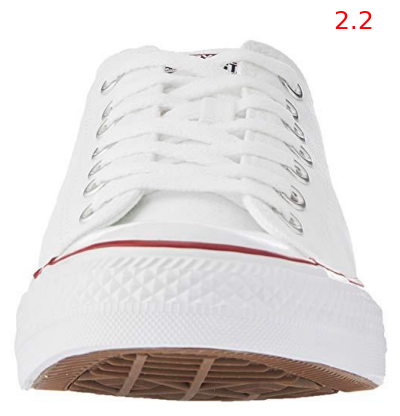

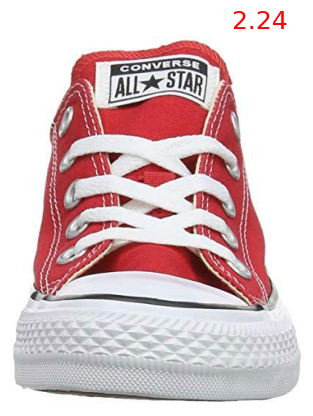

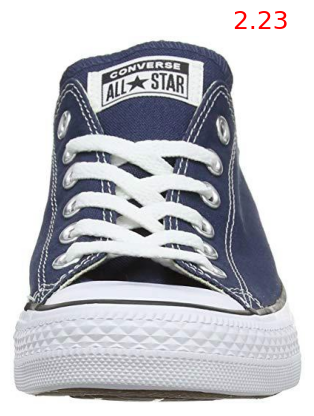

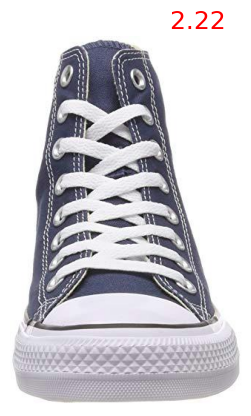

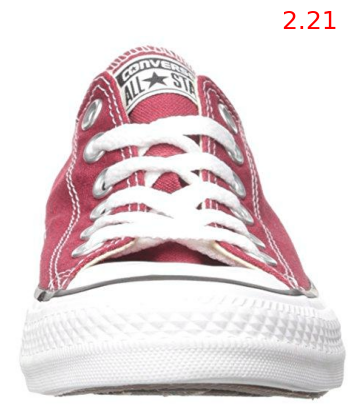

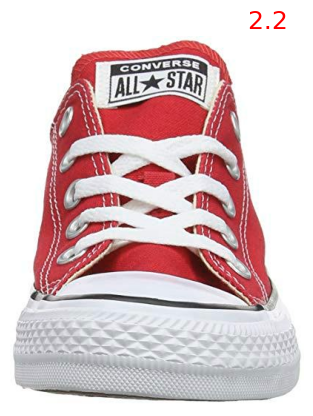

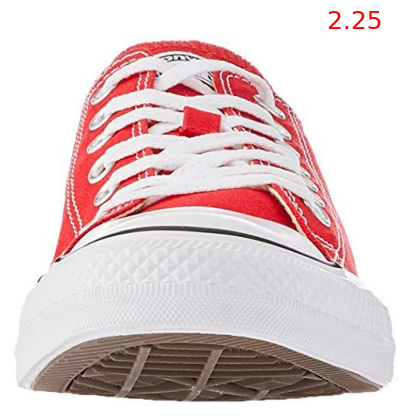

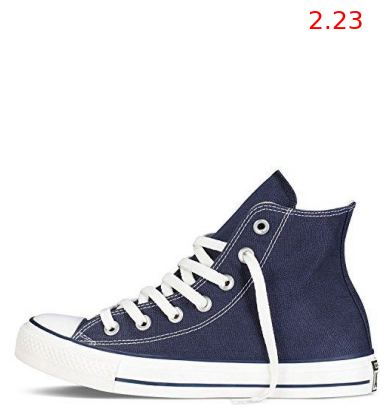

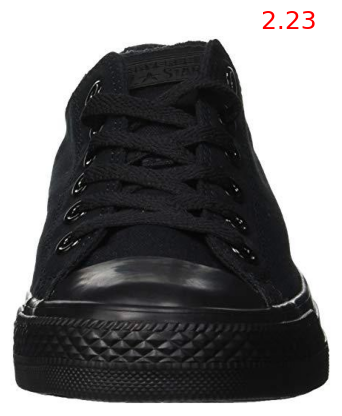

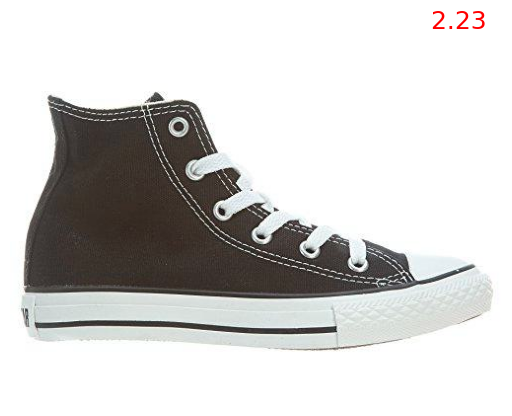

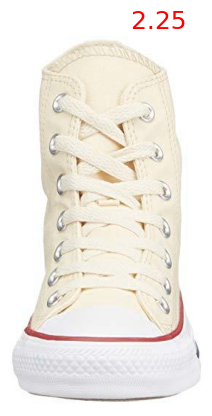

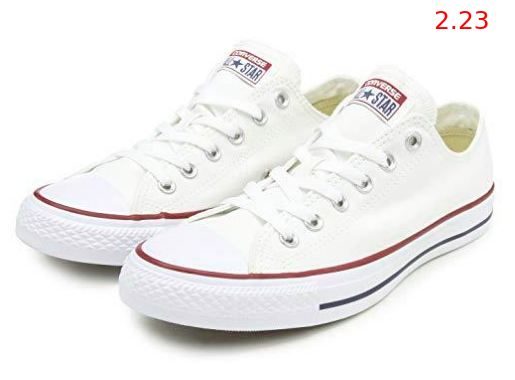

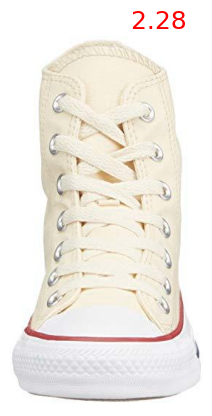

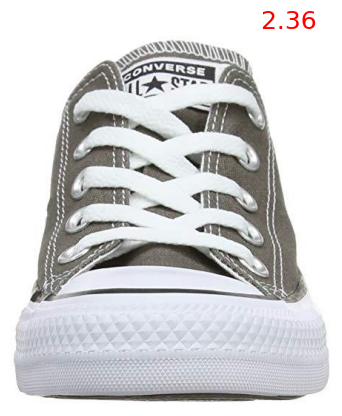

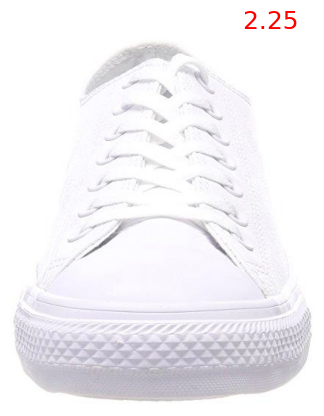

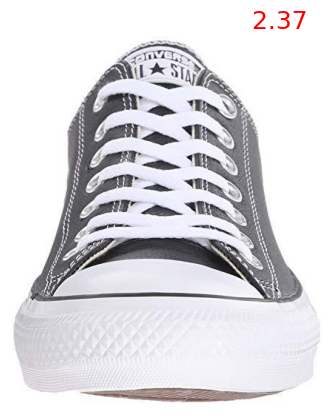

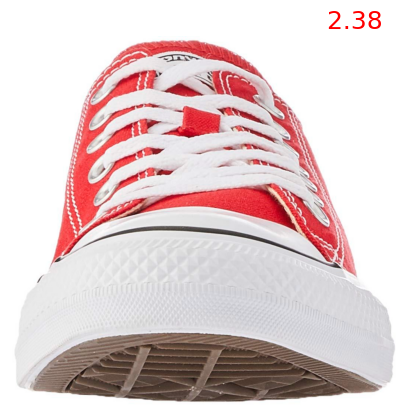

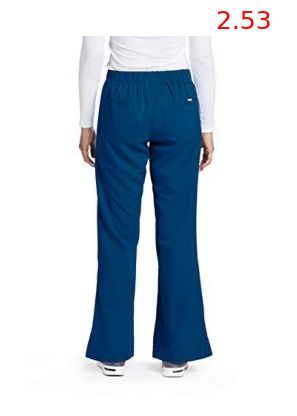

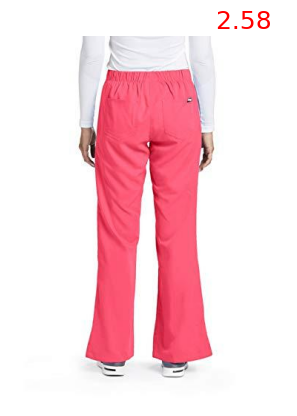

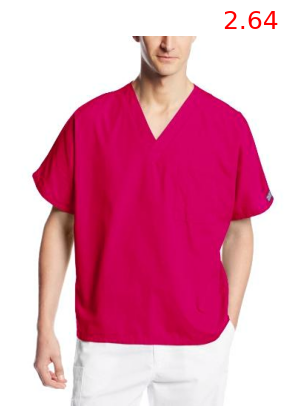

In [36]:
arr = bert('A12LQB0SLYMM3X',20)
print(arr)
for asin in arr:
    img_show_asin(asin , 1)

In [32]:
def hybridRecomm ( userId = 0  ):
    
    
    if  userId not in df3['userID'].values :
        #give top_n model
        a = topRecom( 30 )
        _, idx = np.unique(a, return_index=True)
        a = a[np.sort(idx)]
        
        return a
    
    #calculate numbers of rating done by the user
    
    allUsersRatings = df3.groupby('userID')['userID'].count()
    userRating = allUsersRatings[userId]
    
    #Determining users items 
    
    userDataFrame = df3[df3['userID']== userId ]
    userDataFrame = userDataFrame.sort_values(by=['rating'])
    userAsinProducts = [] 
    for index, row in userDataFrame.iterrows():
            userAsinProducts.append(row['itemID'])
    
    #calculating Avg of Description legnth of All products

    sum1 = 0
    for product in userAsinProducts:
        productIndex = (df2[df2['asin']== product ]).index[0]
        descriptionLen = len(df2[df2['asin']==product]['description'][productIndex])
        sum1 = sum1 + descriptionLen
    avg = sum1 / userRating
    
    
    if (userRating <= 3 ) :
        if(avg <= 400 ):
            recomendedProducts = [] 
            numOfContentBased = round(5/ userRating)
            for product in userAsinProducts:
#                 arr1 = contentBasedDescription(product, numOfContentBased )
                
#                 arr2 = contentBasedBrand(product,numOfContentBased)
                arr1 = contentBased(product, 10)
                arr3 = imgRecomm(product,numOfContentBased)
                recomendedProducts = np.concatenate(  (recomendedProducts ,arr1  , arr3) , axis = None ) 
            recomendedProducts = np.concatenate((recomendedProducts, embedding(userId ,5 ) , topRecom( 10 )) , axis = None  )
            
            
            a = recomendedProducts
            _, idx = np.unique(a, return_index=True)
            a = a[np.sort(idx)]
            
            return a
        else:
            recomendedProducts = [] 
            numOfContentBased = round(5/ userRating)
            for product in userAsinProducts:
#                 arr1 = contentBasedDescription(product, numOfContentBased )
                
#                 arr2 = contentBasedBrand(product,numOfContentBased)
                arr1 = contentBased(product, 10)
                arr3 = imgRecomm(product,numOfContentBased)
                recomendedProducts = np.concatenate( (recomendedProducts ,arr1  , arr3) ,axis = None  )
            
            recomendedProducts =np.concatenate((recomendedProducts, embedding(userId ,10 )) , axis = None)
            
            a = recomendedProducts
            _, idx = np.unique(a, return_index=True)
            a = a[np.sort(idx)]
            
            return a
    else :
        if(avg <= 400 ):
            recomendedProducts = [] 
            if(userRating <= 5 ):
                numOfContentBased = round(5/ userRating)
            else :
                numOfContentBased = 4
            x = 0
            for product in userAsinProducts:
                if (x == 5 ): 
                    break 
                x = x+1 
                

                arr1 = contentBased(product, numOfContentBased)
                arr3 = imgRecomm(product,numOfContentBased)
                recomendedProducts = np.concatenate( (recomendedProducts ,arr1 , arr3) , axis = None)
            
            recomendedProducts = np.concatenate((recomendedProducts ,embedding(userId,15  ) , collabrative (userId ,5)) , axis = None )
            
            a = recomendedProducts
            _, idx = np.unique(a, return_index=True)
            a = a[np.sort(idx)]
            
            return a
        else:
            recomendedProducts = [] 
            if(userRating <= 5 ):
                numOfContentBased = round(5/ userRating)
            else :
                numOfContentBased = 4 
            x = 0
            for product in userAsinProducts:
                if (x == 5 ): 
                    break 
                x = x+1 
                

                arr1 = contentBased(product, numOfContentBased)
                
                recomendedProducts = np.concatenate( (recomendedProducts , arr1 ) , axis = None )
            
           
            recomendedProducts = np.concatenate((recomendedProducts , embedding(userId,10  ) , collabrative (userId ,5)) , axis = None )

            a = recomendedProducts
            _, idx = np.unique(a, return_index=True)
            a = a[np.sort(idx)]
            
            return a
        
        
        

  

In [33]:
hybridRecomm('A23Z52PYAKMXE7')

465/465 [==============================] - 13s 26ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Abdo\\Desktop\\last year\\project\\datasets\\last datataset isa\\current_rating.csv'

In [ ]:
hybridRecomm('A2HM2RMX1CBZGM')



In [ ]:
def writeToCSV ():
    df5= pd.read_csv(r'C:\Users\Abdo\Desktop\last year\project\datasets\last datataset isa\finished_data_isa.csv')
    
    df6 = pd.DataFrame({
    "category": "['Clothing, Shoes & Jewelry', 'Men', 'Shoes', 'Fashion Sneakers']",
    "description": ["afafafafaf"],
    "title":"afsfaf" ,  
    "brand": "asaaf",
    "feature": ["afafafaf"],
    "asin": "fafafdadfaf",
    "imageURLHighRes": ["afsfafafasfafaf"],
    "vote_count": 3,
    "vote_average": 5,
    }, index=[len(df5.index)])
    #
    # Append a dataframe
    #
    df5 = df5.append(df6 )

# category	description	title	brand	feature	asin	imageURLHighRes	vote_count	vote_average

    df5.to_csv(r'C:\Users\Abdo\Desktop\last year\project\datasets\last datataset isa\current_database.csv',index=False)
    return 'done'
